In [1]:
#%pip install --upgrade pip

In [2]:
#%pip install -q -r requirements.txt

# Анализ тарифов компании "Мегалайн"

Я аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.  
Мне предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В моём распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.  

**Описание тарифов**  

**Тариф `«Смарт»`** 
1. Ежемесячная плата: 550 рублей  
2. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика  
3. Стоимость услуг сверх тарифного пакета: 1. минута разговора: 3 рубля («Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута); 2. сообщение: 3 рубля; 3. 1 Гб интернет-трафика: 200 рублей.  

**Тариф `«Ультра»`**  

1. Ежемесячная плата: 1950 рублей
2. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета: 1. минута разговора: 1 рубль; 2. сообщение: 1 рубль; 3. 1 Гб интернет-трафика: 150 рублей.  

*Примечание:
«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.*

## Откроем файл с данными и изучим общую информацию

In [3]:
# импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
# import seaborn as sns
from scipy import stats as st
import math

In [4]:
# считываем файлы с данными
try:
    df_users = pd.read_csv('users.csv', sep=',')
    df_tariffs = pd.read_csv('tariffs.csv', sep=',')
    df_calls = pd.read_csv('calls.csv', sep=',')
    df_internet = pd.read_csv('internet.csv', sep=',')
    df_messages = pd.read_csv('messages.csv', sep=',')
except:
    df_users = pd.read_csv('/datasets/users.csv', sep=',')
    df_tariffs = pd.read_csv('/datasets/tariffs.csv', sep=',')
    df_calls = pd.read_csv('/datasets/calls.csv', sep=',')
    df_internet = pd.read_csv('/datasets/internet.csv', sep=',')
    df_messages = pd.read_csv('/datasets/messages.csv', sep=',')

```python

try:
    # Что-то делаем.
except Exception as e:
    # Обрабатываем исключение.
    # То есть мы ожидаем, что может случиться ошибка.
else:
    # Выполянем что-то, если нет ошибок.
finally:
    # Выполянем что-то при любом раскладе.
    
```

In [5]:
# смотрим информацию по таблице `users`
display(df_users.head())
print(df_users.info(), 'Всего уникальных пользователей', df_users['user_id'].nunique())

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None Всего уникальных пользователей 500


Согласно документации таблица users (информация о пользователях):    
`user_id` — уникальный идентификатор пользователя  
`first_name` — имя пользователя  
`last_name` — фамилия пользователя  
`age` — возраст пользователя (годы)  
`reg_date` — дата подключения тарифа (день, месяц, год)  
`churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)  
`city` — город проживания пользователя  
`tarif` — название тарифного плана  

В таблице 500 записей, каждая представляет собой данные о 500 уникальных пользователях.   
38 пользователей прекратили пользоваться тарифным планом на момент выгрузки данных.  
Столбцы `reg_date` и `churn_date` представляют собой даты в формате год-месяц-день. Далее мы переведём их в соответствующий формат даты.   Остальные данные предварительно у нас не вызывают вопросов.

In [6]:
# смотрим таблицу тарифных планов
display(df_tariffs.head())
df_tariffs.info()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


Согласно документации таблица tariffs (информация о тарифах):    
* tariff_name — название тарифа
* rub_monthly_fee — ежемесячная абонентская плата в рублях
* minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
* messages_included — количество сообщений в месяц, включённых в абонентскую плату
* mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* rub_per_message — стоимость отправки сообщения сверх тарифного пакета
* rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)  

Мы видим две записи по тарифным планам. Данные соответствуют тарифным планам.

In [7]:
# таблица информация о звонках
display(df_calls.head())
df_calls.info()
df_calls.loc[df_calls['duration'] == 0, 'duration'].count()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


39613

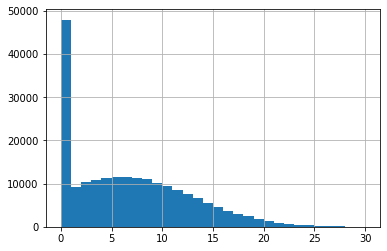

In [8]:
# построили гистрограмму посмотреть разброс
df_calls['duration'].hist(bins=30, range=(0, 30))
plt.show()

 Согласно документации таблица calls (информация о звонках):  
* id — уникальный номер звонка
* call_date — дата звонка
* duration — длительность звонка в минутах
* user_id — идентификатор пользователя, сделавшего звонок  

По таблице звонков у нас всего 202 067 записей. По столбцам `call_date` будет правильно перевести в тип дата. Мы построили диаграмму, чтобы визуально оценить звонки и видим, что очень много звонков с нулевым значением. Согласно пояснениям это пропущенные звонки абонентов. Также согласно примечанию, все звонки округляются до целых для тарифных планов, даже если звонок был 1 секунду, он будет засчитан, как 1 минута. Поэтому длительность звонков мы переведём в тип Int c округлением в большую сторону. Воспользуемся функцией ceil() для округления в большую сторону до целого числа.

In [9]:
display(df_messages.head())
df_messages.info()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Cогласно документации таблица messages (информация о сообщениях):
* id — уникальный номер сообщения
* message_date — дата сообщения
* user_id — идентификатор пользователя, отправившего сообщение  

В таблице 3 столбца. Столбец `message_date` переведем в тип дата. По остальным вопросов нет.

In [10]:
display(df_internet.head())
df_internet.info()
# проверяем количество нулей в значениях использования интернета
df_internet.loc[df_internet['mb_used'] == 0,'mb_used'].count() / df_internet.shape[0]

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


0.13118155773916304

In [11]:
# смотрю выборку по пользователю, у которого есть нулевое потребление трафика интернета
df_internet[df_internet['user_id'] == 1000].sort_values(by='session_date')

,Unnamed: 0,id,mb_used,session_date,user_id
103,103,1000_103,0.00,2018-05-26,1000
96,96,1000_96,544.22,2018-05-28,1000
59,59,1000_59,363.20,2018-05-28,1000
51,51,1000_51,628.41,2018-05-31,1000
134,134,1000_134,717.66,2018-05-31,1000
...,...,...,...,...,...
58,58,1000_58,10.23,2018-12-28,1000
143,143,1000_143,0.00,2018-12-29,1000
197,197,1000_197,178.76,2018-12-29,1000
194,194,1000_194,369.19,2018-12-30,1000


По описанию документации таблица содержит internet (информация об интернет-сессиях):
* id — уникальный номер сессии
* mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
* session_date — дата интернет-сессии
* user_id — идентификатор пользователя

Мы видим, то в таблице появился неучтенный столбец `Unnamed: 0`, который повторяет индексацию таблицы. Удалим его, так как он совсем лишний столбец в нашей таблице. Столбец с датами также следует перевести в тип дата. 

## Подготовка данных

### Приведем данные к нужным типам и исправим ошибки в данных

In [12]:
# перевод даты в привычный формат в таблице users
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'], format='%Y-%m-%d')
df_users['churn_date'] = pd.to_datetime(df_users['churn_date'], format='%Y-%m-%d')

In [13]:
# перевод даты в привычный формат в таблице calls
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'], format='%Y-%m-%d')

In [14]:
# огруглим столбец `duration` до целых чисел в большую сторону, так звонки в "Мегалайне" округляются в большую сторону 
# до минут и переведём в тип Int
np.ceil(df_calls['duration'])
df_calls['duration'] = df_calls['duration'].astype('int64')

In [15]:
# перевод даты в привычный формат в таблице df_messages
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'], format='%Y-%m-%d')

In [16]:
# перевод даты в привычный формат в таблице df_internet
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'], format='%Y-%m-%d')
# удалим лишний столбец Unnamed: 0 в таблице df_internet
df_internet = df_internet.drop('Unnamed: 0', 1)

Мы привели даты к типам дата в таблицах, удалили лишний столбец в таблице `internet`, огруглили к целым минутам длительность звонков в минутах в таблице `calls`.  

### Объединение таблиц и расчет данных для каждого пользователя

Посчитаем для каждого пользователя:  
* количество сделанных звонков и израсходованных минут разговора по месяцам;
* количество отправленных сообщений по месяцам;
* объем израсходованного интернет-трафика по месяцам;
* помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

Подотовим данные для расчётов. Для этого объединим таблицы `users`, `calls`, `messages`, `internet`

In [17]:
# функция, добавляющая в таблицу столбец `column_month` число соответствующее месяцу от 
# даты в столбце `column_month`, а после переводящая столбец в тип int, так как сразу приводит к float

def df_month_add(df, column, column_month):
    df[column_month] = pd.DatetimeIndex(df[column]).month
    df[column_month] = df[column_month].astype('int8')

In [18]:
# функция, запускающая сначала функцию добавления месяца столбца в таблицу, а потом группирует данные по user_id
# и месяцу и возвращающая новый датафрейм

def group_id_month(df, column, column_month, user_id, agg_column, func):
    df_month_add(df, column, column_month)
    return df.groupby([user_id, column_month]).agg({agg_column: func}).reset_index()


In [19]:
# сгруппируем последовательно `calls`, `messages`, `internet` таблицы по 'user_id' и месяцу в новые датафреймы
df_calls_group = group_id_month(df_calls, 'call_date', 'month', 'user_id', 'duration', sum)
df_messages_group = (group_id_month(df_messages, 'message_date', 'month', 'user_id', 'id', 'count').
                     rename(columns={"id": "sms"}))
df_internet_group = group_id_month(df_internet, 'session_date', 'month', 'user_id', 'mb_used', sum)

In [20]:
# объединим данные в таблицах со звонками, сообщениями и трафиком интернета
df_user_group = pd.merge(df_calls_group, df_messages_group, how='outer')
df_user_group = df_user_group.merge(df_internet_group, how='outer')

In [21]:
# соединяем таблицу 'users' c группированными данными звонков, сообщений и потребления интернета
df_user_group = df_users.merge(df_user_group, how='outer')

In [22]:
# переименуем столбец с тарифным планом для дальнейшего объединения таблицы со сводной
df_tariffs = df_tariffs.rename(columns={"tariff_name": "tariff"})
# соединяем сводную таблицу с таблицей df_tariffs
df_user_group = df_user_group.merge(df_tariffs, how='left')

In [23]:
df_user_group.loc[df_user_group['mb_used'] == 0, 'mb_used'].count()

2

### Промежуточные выводы после объединения таблиц

Подготовили данные для расчёта.    
Мы соединили все данные по каждому пользователю в одну таблицу, чтобы далее иметь возможнось делать расчёты по каждому месяцу и определять затраты пользователя и в конечном итоге сделать вывод о лучшем тарифе.  
Теперь работаем с общей таблицей `df_user_group`

In [24]:
# смотрим общую инфо по сводной таблице
df_user_group.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 19 columns):
user_id                  3216 non-null int64
age                      3216 non-null int64
churn_date               189 non-null datetime64[ns]
city                     3216 non-null object
first_name               3216 non-null object
last_name                3216 non-null object
reg_date                 3216 non-null datetime64[ns]
tariff                   3216 non-null object
month                    3214 non-null float64
duration                 3174 non-null float64
sms                      2717 non-null float64
mb_used                  3203 non-null float64
messages_included        3216 non-null int64
mb_per_month_included    3216 non-null int64
minutes_included         3216 non-null int64
rub_monthly_fee          3216 non-null int64
rub_per_gb               3216 non-null int64
rub_per_message          3216 non-null int64
rub_per_minute           3216 non-null int64
dtypes: d

Заметил, что столбец 'month' опять стал float - это могло произойти по причине наличия пустых значений.  
Проверим, что это за значения и почему они образовались

In [25]:
# выводим строки по пустым значениям по месяцам
df_user_group[df_user_group['month'].isna()]

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,duration,sms,mb_used,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
827,1128,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra,NaN,NaN,NaN,NaN,1000,30720,3000,1950,150,1,1
2335,1371,50,2018-12-30,Омск,Ириней,Трофимов,2018-12-25,smart,NaN,NaN,NaN,NaN,50,15360,500,550,200,3,3


Мы видим, что это два пользователя, которые зарегистрировались в конце декабря и через +- неделю закрыли тарифный план, так и не сделав ни одного звонка, не написав сообщений и не пользовавшись интернетом.  
Это явные выбросы в данном контексте, поэтому удалим строки с этими пользователями. 

In [26]:
# удаляем нулевые значений по месяцу и проверяем правильность выполнения
df_user_group = df_user_group.loc[~df_user_group['month'].isna()]
df_user_group['month'].isna().sum()

0

In [27]:
# приведём месяц к типу int
df_user_group['month'] = df_user_group['month'].astype('int8')

In [28]:
df_user_group.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,duration,sms,mb_used,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,142.0,22.0,2253.49,1000,30720,3000,1950,150,1,1
1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6,144.0,60.0,23233.77,1000,30720,3000,1950,150,1,1
2,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7,299.0,75.0,14003.64,1000,30720,3000,1950,150,1,1
3,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8,367.0,81.0,14055.93,1000,30720,3000,1950,150,1,1
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9,421.0,57.0,14568.91,1000,30720,3000,1950,150,1,1


In [29]:
# функция, считающая помесячную выручку каждого пользователя
def user_sum_month(df):
    result = df['rub_monthly_fee'] # присваиваем result абоненскую плату
# проверяем в каждом условиии по очереди условия превышения включения бесплатных минут, смс и интернета
# при превышении условий включения добавляем стоимость дополнительных услуг
    if (df['duration'] - df['minutes_included']) > 0: 
        result += (df['duration'] - df['minutes_included']) * df['rub_per_minute']
    if (df['sms'] - df['messages_included']) > 0:
        result += (df['sms'] - df['messages_included']) * df['rub_per_message']
    if (df['mb_used'] - df['mb_per_month_included']) > 0:
        result += math.ceil((df['mb_used'] - df['mb_per_month_included']) / 1024) * df['rub_per_gb']
    return result

In [30]:
# добавим столбец в сводную таблицу выручку с каждого пользователя помесячно
df_user_group['sum_month'] = df_user_group.apply(user_sum_month, axis=1)

## Анализ данных

Опишим поведение клиентов оператора, исходя из выборки.   
Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц?   
Посчитаем среднее количество, дисперсию и стандартное отклонение. Построем гистограммы. Опишим распределения.

In [31]:
# функция рисует диаграмму среднего использования услуги по тарифам в каждом из месяцев 
def user_bar(df, column, ylabel='', title=''):
    df_user_group1 = (df_user_group.groupby(['tariff', 'month']).agg({column : 'mean'})
    .query('tariff =="ultra"').reset_index().drop('tariff', 1))
    
    df_user_group2 = (df_user_group.groupby(['tariff', 'month']).agg({column : 'mean'})
    .query('tariff =="smart"').reset_index().drop('tariff', 1))
    
    fig, ax = plt.subplots()
# сдвигаем колонки влева и вправо на 0,2, чтобы они расположились рядом
    ax.bar(df_user_group1['month'] - 0.2, df_user_group1[column], width = 0.4, label = ('ultra'))
    ax.bar(df_user_group2['month'] + 0.2, df_user_group2[column], width = 0.4, label = ('smart'))
# устанавливаем фон внутри графика
    ax.set_facecolor('seashell')
# устанавливаем размеры графика
    fig.set_figwidth(12)    
    fig.set_figheight(6)    
# устанавливаем фон снаружи графика
    fig.set_facecolor('floralwhite')
# устанавливаем оси графика
    ax.set_xlabel('месяц')
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    plt.legend()

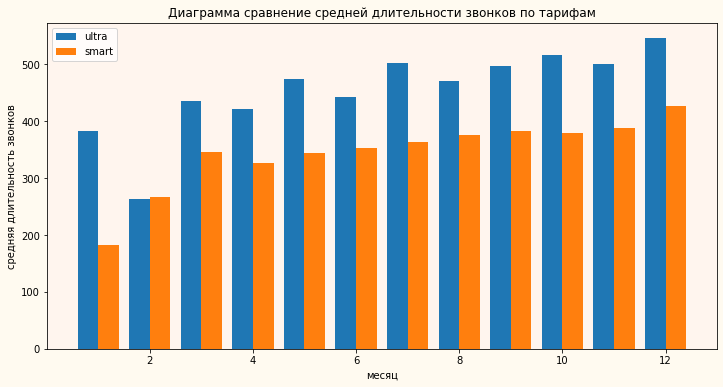

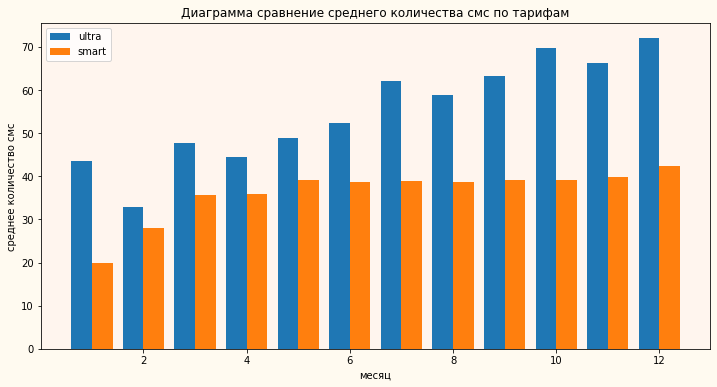

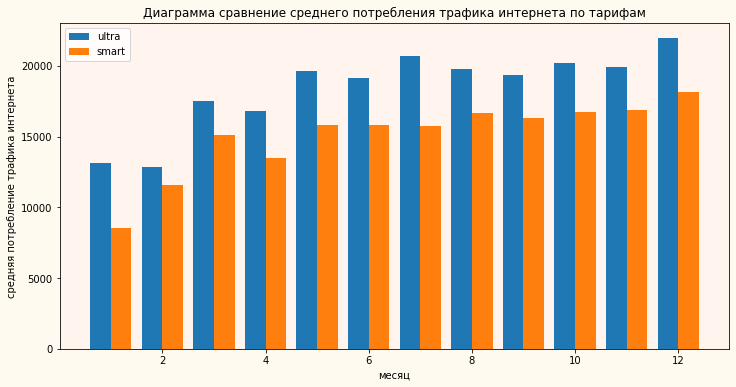

In [32]:
# строим диаграммы оказанных услуг по тарифам помесячно
user_bar(df_user_group, 'duration', 'средняя длительность звонков', \
         'Диаграмма сравнение средней длительности звонков по тарифам')

user_bar(df_user_group, 'sms', 'среднее количество смс', \
         'Диаграмма сравнение среднего количества смс по тарифам')

user_bar(df_user_group, 'mb_used', 'средняя потребление трафика интернета', \
         'Диаграмма сравнение среднего потребления трафика интернета по тарифам')

plt.show()

По диаграмам видно, что в начале года было меньше среднее по всем услугам, постепенно увеличиваясь в течении года. 

Тариф **smart** пользователи в среднем вкладываются по услугам во включенный пакет, по пакету интернет-трафика есть в некоторых месяцах превышения.    
По тарифу **ultra** есть большой запас пакетного плана по всем показателям. Превышение может быть только по отдельным пользователям. В среднем пользователям с запасом хватает включенных услуг.

In [33]:
# функция рисует гистрограмму сравнение использования услуг в среднем помесячно
def user_hist_mean(df, column, xlabel='', title='', bins=24):
# считает выборку среднего по тарифу и месяцу, удаляю лишние колонки, оставляя только значения оказанных услуг
# чтобы получить Series
    ax = df_user_group.groupby(['tariff', 'month']).agg({column : 'mean'}) \
    .query('tariff =="ultra"').reset_index().drop(['tariff', 'month'],1) \
    .hist(bins=bins, alpha=0.8, figsize=(12,6))
# выборка по второму тарифу    
    df_user_group.groupby(['tariff', 'month']).agg({column : 'mean'}) \
    .query('tariff =="smart"').reset_index().drop(['tariff', 'month'],1) \
    .hist(bins=bins, alpha=0.2, ax=ax, figsize=(12,6))
# название гистрограммы
    plt.title(title)
# название по оси х
    plt.xlabel(xlabel)
    plt.ylabel("Количество значений")
# легенда графика
    plt.legend(['ultra','smart'])   

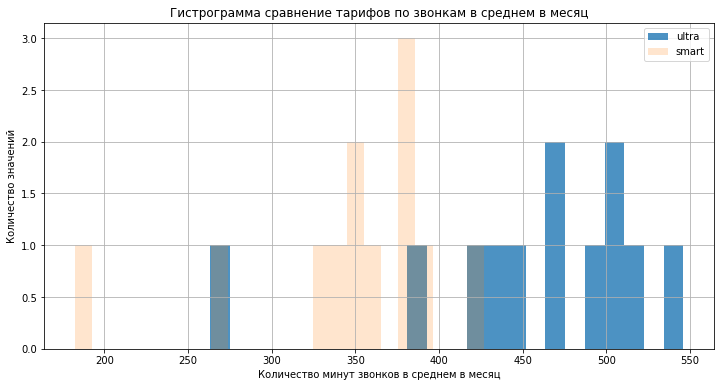

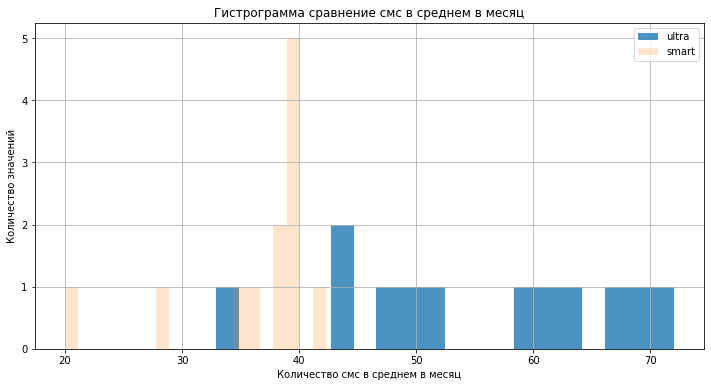

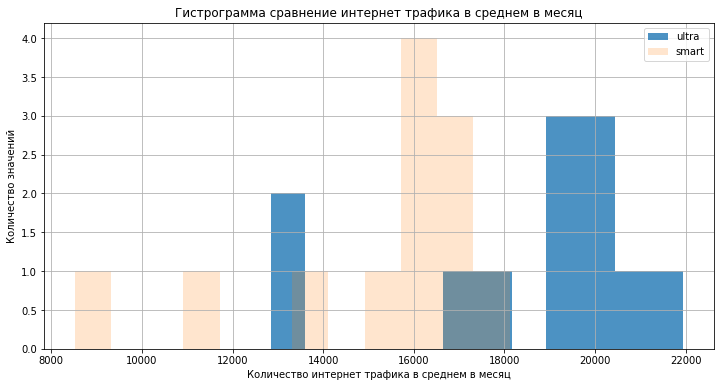

In [34]:
# строим гистрограммы по среднему в оказанных услугам по тарифам в каждом месяце
user_hist_mean(df_user_group, 'duration', 
               xlabel='Количество минут звонков в среднем в месяц', 
               title='Гистрограмма сравнение тарифов по звонкам в среднем в месяц', bins=24)

user_hist_mean(df_user_group, 'sms', 
               xlabel='Количество смс в среднем в месяц', 
               title='Гистрограмма сравнение смс в среднем в месяц', bins=20)

user_hist_mean(df_user_group, 'mb_used', 
               xlabel='Количество интернет трафика в среднем в месяц', 
               title='Гистрограмма сравнение интернет трафика в среднем в месяц', bins=12)

plt.show()

По гистограммам мы видим:  
* `тариф смарт` - в месяц чаще всего среднее по звонкам 350, 380 минут; 39 смс; 15-16 Гб  
* `тариф ультра` - в месяц чаще всего среднее по звонкам 470, 500 минут, значения более плотные, но с выбросами по месяцам; значения по смс также плотные в основном разброс 45-70 смс; 20-21 Гб в среднем потребление трафика интернета 

In [35]:
# функция показывает на гистрограмме количество оказанных услуг в колонке в зависимости от тарифа  
def user_tariff_hist(df, column, bins=10, title='', xlabel=''):
# делаем выборку по тарифу по выбранной колонке услуг
    df.groupby('tariff')[column].plot.hist(alpha=0.5, legend=True, bins=25, figsize=(10,8))
    plt.title(title)
# метка по оси х
    plt.xlabel(xlabel)
    plt.ylabel("Количество значений")
    plt.legend(['smart','ultra']) 
    plt.show()

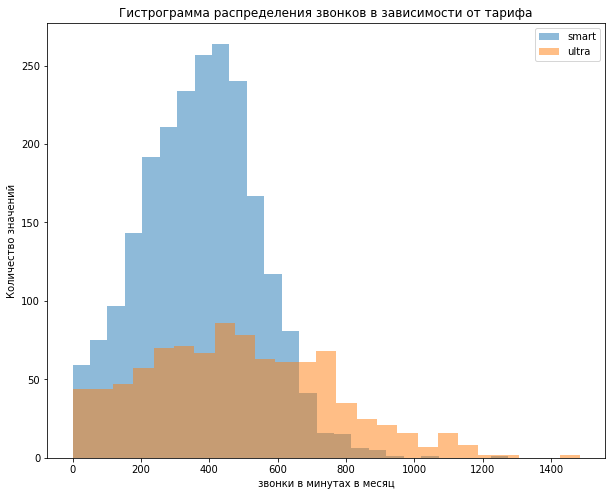

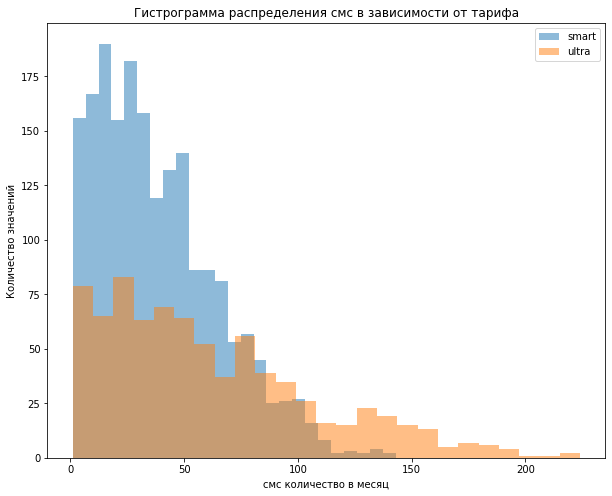

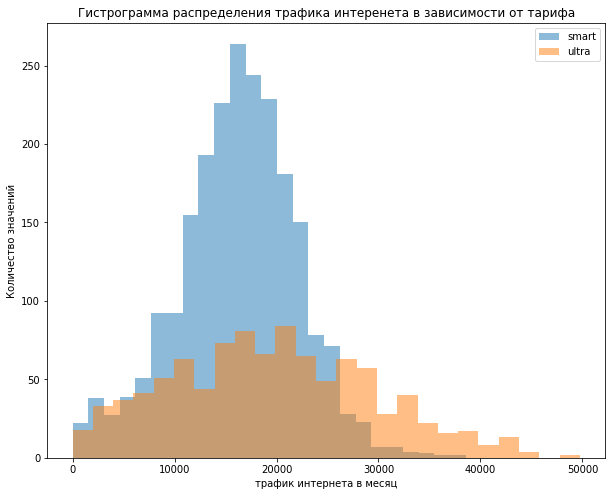

In [36]:
# строим гистрограммы распределения услуг по тарифным планам
user_tariff_hist(df_user_group, 'duration', 25, \
                 'Гистрограмма распределения звонков в зависимости от тарифа', 'звонки в минутах в месяц')

user_tariff_hist(df_user_group, 'sms', 10, \
                 'Гистрограмма распределения смс в зависимости от тарифа', 'смс количество в месяц')

user_tariff_hist(df_user_group, 'mb_used', 15, \
                 'Гистрограмма распределения трафика интеренета в зависимости от тарифа', \
                 'трафик интернета в месяц')

In [37]:
# функция, считает дисперсию по выборке
def sample_variance(df):
# параметр ddof=1 указывает, что это дисперсия выборки c одной степенью свободы
    return np.var(df, ddof=1)

In [38]:
# функция, считает стандартное отклонение по выборке
def standard_dev(df):
# параметр ddof=1 указывает, что это стандартное отклонение выборки с одной степенью свободы
    return np.std(df, ddof=1)

In [39]:
# создаем сводную таблицу по тарифам по каждой из услуг (звонки, смс, интернет) по данным (среднее, дисперсия
# и стандартное отклонение)
df_mean_var_std = (df_user_group.groupby('tariff')
        .agg({'duration' : ['mean', sample_variance, standard_dev], 
         'sms' : ['mean', sample_variance, standard_dev],
         'mb_used' : ['mean', sample_variance, standard_dev]}).round(2).reset_index())

df_mean_var_std

tariff duration                                 sms                  \
             mean sample_variance standard_dev   mean sample_variance   
0  smart   372.45        28565.31       169.01  38.72          717.59   
1  ultra   484.65        74640.05       273.20  61.16         2109.66   

                 mb_used                               
  standard_dev      mean sample_variance standard_dev  
0        26.79  16215.66     34359951.68      5861.74  
1        45.93  19668.49     98864248.95      9943.05

### Промежуточные выводы по анализу данных

Мы посчитали среднее количество, дисперсию и стандартное отклонение по выборке пользователей в зависимости от тарифа.  
* по звонкам в среднем пользователи тарифного плана *ультра* разговаривают на 110 минут больше, чем пользователи тарифного плана *смарт*, дисперсия в 2,5 раза больше и стандартное отклонение 270 против 169.  
* по смс в среднем пользователи тарифного плана *ультра* 1,5 чаще пользуются данной услугой, дисперсия превышает в 3 раза пользователей тарифного плана *смарт*, стандартное отклонение 46 против 27.  
* потребление интернет трафика в среднем у пользователей тарифных планов не сильно различается - разница в 3 Гб больше у пользователей тарифного плана *ультра*, однако у пользователей плана *смарт* это предел или даже небольшое превышение включенного в пакет, в в пакете *ультра* есть большой запас; дисперсия и стандартное отклонение просто огромны - это говорит о том, что поведение пользователей в части использования интернета сильно отличается между собой.  

Как мы могли видеть видеть, пользование услугами в начале года было меньше в среднем относительно всего года и постепенно увеличивалось по месяцам.  
Пользователи тарифного плана *смарт* используют услуги включенные в пакет почти под самый верх включенных, а по потреблению трафика интернета даже в некоторых месяцах с превышением в среднем.  
У пользователей тарифного плана *ультра* в среднем есть большой запас по всем услугам, включенным в абоненскую плату.

## Проверяем гипотизы

* средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
* средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

### Гипотиза о равенстве выручки от пользователей по тарифным планам

**Сформулируем нулевую гипотизу. Она будет звучать так.** 
**Ho** ---> *средняя выручка пользователей тарифов "Ультра" и "Смарт" равны.*  
**H1** ---> *средняя выручка пользователей тарифов "Ультра" и "Смарт" различаются.*  
Зададим alpha = 0.05  -  критический уровень статистической значимости  
Для проверки гипотизы выберем критерий равенства средних двух генеральных совокупностей по взятым из них выборок. 

In [40]:
# задаем уровень значимости
alpha = 0.05

In [41]:
# проверяю количество выборок по тарифным планам
df_user_group.groupby('tariff').agg({'sum_month' : 'count'})

,sum_month
tariff,
smart,2229
ultra,985


In [42]:
# проверим дисперсии двух выборок на гомогенность
stat_smart_ultra, p_smart_ultra = (st.levene(df_user_group[df_user_group['tariff'] == 'ultra']['sum_month'], 
                    df_user_group[df_user_group['tariff'] == 'smart']['sum_month']))
if p_smart_ultra < alpha:
    print('Дисперсии выборок различны')
else:
    print('Дисперсии выборок гомогенны')

Дисперсии выборок различны


In [43]:
# проверяем гипотезу о равенстве двух средних
# equal_var=False устанавливливаем, так как дисперсии выборок различаются
results_ultra_smart = st.ttest_ind(df_user_group[df_user_group['tariff'] == 'ultra']['sum_month'],
                                   df_user_group[df_user_group['tariff'] == 'smart']['sum_month'], equal_var=False)

# если p-value results_ultra_smart окажется меньше установленного alpha - отвергнем гипотезу
print('p-значение:', results_ultra_smart.pvalue)

if results_ultra_smart.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')
print('Значения средних: ')
display(df_user_group.groupby("tariff").agg({"sum_month" : "mean"}).round(0).reset_index())

p-значение: 5.5514986360950055e-295
Отвергаем нулевую гипотезу
Значения средних: 


,tariff,sum_month
0,smart,1231.0
1,ultra,2070.0


Мы отвергли нулевую гипотизу. Получается принимаем альтернативную гипотизу.  
**Средняя выручка пользователей тарифов "Ультра" и "Смарт" различаются.**  
По выборке мы видим среднее значение выручки пользователей тарифного плана *'Ультра'* равняется **2070 рублей**, а выручка от пользователей тарифного плана *'Смарт'* **1231 рублей**.  
Согласно ЦПТ, выборочные средние распределены нормально вокруг истинного среднего генеральной совокупности, поэтому может судить о средних  значений выборки, как о стремящихся к средним значениям генеральной совокупности. 

### Гипотиза о равенстве выручки пользователей из Москвы и других городов

**Сформулируем нулевую гипотизу.**   
**Ho** ---> *средняя выручка пользователей из Москвы равна выручке пользователей из других регионов.*  
**H1** ---> *средняя выручка пользователей отличается от выручки пользователей из других регионов.*  
Зададим alpha = 0.05  
Для проверки гипотизы выберем критерий равенства средних двух генеральных совокупностей по взятым из них выборок. 

In [44]:
# добавляем столбец со значениями городов, чтобы далее те, что не Москва назвать единым значением
df_user_group['city_another'] = df_user_group['city']

In [45]:
# в столбце 'city_another' меняем город, если не Москва на 'другие'. После проверяем список городов
df_user_group.loc[df_user_group['city_another'] != 'Москва', 'city_another'] = 'другие' 
df_user_group['city_another'].unique()

array(['другие', 'Москва'], dtype=object)

In [46]:
# проверяю количество выборок по тарифным планам
df_user_group.groupby('city_another').agg({'sum_month': 'count'})

,sum_month
city_another,
Москва,611
другие,2603


In [47]:
# проверим дисперсии двух выборок на гомогенность
stat_city, p_city = (st.levene(df_user_group[df_user_group['city_another'] == 'Москва']['sum_month'], 
                    df_user_group[df_user_group['city_another'] == 'другие']['sum_month']))
if p_city < alpha:
    print('Дисперсии выборок различны')
else:
    print('Дисперсии выборок гомогенны')

Дисперсии выборок гомогенны


In [48]:
# проверяем гипотезу о равенстве двух средних
results_city = st.ttest_ind(df_user_group[df_user_group['city_another'] == 'Москва']['sum_month'],
                                   df_user_group[df_user_group['city_another'] == 'другие']['sum_month'])

# если p-value results_city окажется меньше установленного alpha - отвергнем гипотезу
print('p-значение:', results_city.pvalue)

if results_city.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')
print('Значения средних: ')
display(df_user_group.groupby('city_another').agg({'sum_month': 'mean'}).round(0).reset_index())

p-значение: 0.4495612335173296
Не получилось отвергнуть нулевую гипотезу
Значения средних: 


,city_another,sum_month
0,Москва,1510.0
1,другие,1483.0


Мы принимаем нулевую гипотизу.    
**Средняя выручка пользователей из Москвы равна выручке пользователей из других регионов.**

## Общий вывод

**Как мы могли проанализировать, пользователи тарифного плана *смарт* используют услуги включенные в пакет почти под самый потолок включенных, а по потреблению трафика интернета даже в некоторых месяцах с превышением в среднем. За счёт дорогих услуг сверх тарифа, пользователь приносит столько же и даже немного больше дополнительно к абоненской плате.      
У пользователей тарифного плана *ультра* в среднем есть большой запас по всем услугам, включенным в абоненскую плату.  
Однако, в связи с большой разницей в абоненской плате, даже с учётом дополнительной оплаты пользователей тарифного плана *смарт* сверх абоненской платы, пользователи тарифного плана *ультра* приносят компании "Мегалайн" в 1,7 раза больше денег, чем пользователи тарифного плана *смарт*                
Также мы выяснили, что средняя выручка пользователей из Москвы равна выручке пользователей из других регионов.**